# Task 1

---

## Web scraping and analysis

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

In [49]:
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import trange, tqdm
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

COLOR_FONT = 'dimgray'
COLOR_PLOT = 'tan'

plt.rcParams.update(
    {
        'figure.figsize': [9, 5],
        'text.color': COLOR_FONT,
        'axes.edgecolor': COLOR_FONT,
        'axes.labelcolor': COLOR_FONT,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.titlecolor': COLOR_FONT,
        'axes.titlesize': 18,
        'xaxis.labellocation': 'left',
        'yaxis.labellocation': 'top',
        'xtick.color': COLOR_FONT,
        'ytick.color': COLOR_FONT,
        'xtick.bottom': False,
        'ytick.left': False,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
    }
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Scar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Scar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Scar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'

PAGE_SIZE = 100

response = requests.get(base_url)

content = response.content

soup = BeautifulSoup(content, 'html.parser')

num_reviews = int(
    soup.find('div', {'class': 'pagination-total'}).get_text().split(' ')[-2]
)
num_pages = num_reviews // PAGE_SIZE + 1
num_pages

38

In [3]:
rating = []
rating_category = []

df = pd.DataFrame()

for page in trange(1, num_pages + 1):
    url = f'{base_url}/page/{page}/?sortby=post_date%3ADesc&pagesize={PAGE_SIZE}'

    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    for pars_review in parsed_content.find_all('article', {'itemprop': 'review'}):

        try:
            rating_value = pars_review.find(
                'span', {'itemprop': 'ratingValue'}
            ).get_text()
        except Exception:
            rating_value = None

        date_string = (
            pars_review.find('time', {'itemprop': 'datePublished'})
            .get_text()
            .split(' ', 1)[-1]
        )
        date_review = datetime.strptime(date_string, '%B %Y')

        try:
            country = (
                pars_review.find('h3', {'class': 'text_sub_header'})
                .get_text()
                .split('(')[1]
                .split(')')[0]
            )
        except Exception:
            country = None

        reviews = pars_review.find('div', {'class': 'text_content'}).get_text()

        para = pars_review.find('div', {'class': 'review-stats'})
        for para1 in para.find_all('td', {'class': 'review-value'}):
            rating.append(para1.get_text())
        recommend = rating[-1]
        rating = rating[:-1]

        for para2 in para.find_all('td', {'class': 'review-rating-stars'}):
            rating.append(len(para2.find_all('span', {'class': 'star fill'})))
        rating.append(recommend)

        for para3 in para.find_all('td', {'class': 'review-rating-header'}):
            rating_category.append(para3.get_text())

        df1 = pd.DataFrame(
            {
                'date_review': [date_review],
                'country': [country],
                'rating_value': [rating_value],
                'reviews': [reviews],
            }
        )
        df2 = pd.DataFrame(data=[rating], columns=rating_category)
        data1 = pd.concat([df1, df2], axis=1)

        df = pd.concat([df, data1], ignore_index=True).reset_index(drop=True)
        rating = []
        rating_category = []

100%|██████████| 38/38 [01:28<00:00,  2.32s/it]


In [4]:
df.sample(5)

,date_review,country,rating_value,reviews,Type Of Traveller,Seat Type,Route,Date Flown,Ground Service,Value For Money,Recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Aircraft,Wifi & Connectivity
3300,2015-01-01,United Kingdom,2,Muscat - Abu Dhabi - London. Delayed over two ...,NaN,Premium Economy,NaN,NaN,NaN,4,no,4.0,1.0,3.0,4.0,NaN,NaN
3409,2014-11-01,United Kingdom,4,31.10.14 - LHR to Berlin Tegel. Flight out goo...,NaN,Economy Class,NaN,NaN,NaN,3,no,3.0,1.0,1.0,1.0,NaN,NaN
870,2019-09-01,United Kingdom,8,✅ Trip Verified | Glasgow to Tampa via Gatwic...,Couple Leisure,Business Class,Glasgow to Tampa via Gatwick,September 2019,5.0,4,yes,4.0,5.0,3.0,3.0,A319 / Boeing777,NaN
2765,2015-10-01,United States,2,We paid for World Traveller Plus (Premium Econ...,Couple Leisure,Premium Economy,DFW to LHR,September 2015,3.0,2,no,3.0,4.0,4.0,3.0,Boeing 777-300,3.0
921,2019-07-01,United Arab Emirates,10,✅ Trip Verified | London to Dubai. Lately I a...,Solo Leisure,Premium Economy,London to Dubai,July 2019,5.0,5,yes,5.0,5.0,3.0,5.0,Boeing 777,5.0


Rename columns.

In [5]:
df.columns = df.columns.str.lower().str.replace('& ', '').str.replace(' ', '_')

In [6]:
df.shape

(3798, 17)

In [7]:
df.to_csv('data/BA_reviews.csv', index=False)

### Cleaning data

 The next thing is cleaning this data to remove any unnecessary text from each of the rows. For example, '✅ Trip Verified' can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_review             3798 non-null   datetime64[ns]
 1   country                 3796 non-null   object        
 2   rating_value            3793 non-null   object        
 3   reviews                 3798 non-null   object        
 4   type_of_traveller       3027 non-null   object        
 5   seat_type               3796 non-null   object        
 6   route                   3023 non-null   object        
 7   date_flown              3020 non-null   object        
 8   ground_service          2950 non-null   float64       
 9   value_for_money         3798 non-null   int64         
 10  recommended             3798 non-null   object        
 11  seat_comfort            3676 non-null   float64       
 12  cabin_staff_service     3664 non-null   float64 

Convert `date_reviews` to `year`.

In [9]:
df['year'] = df['date_review'].dt.year

In [10]:
df['year'].value_counts(dropna=False).sort_index()

2011      3
2012     12
2014    468
2015    738
2016    570
2017    572
2018    324
2019    356
2020    104
2021     87
2022    213
2023    280
2024     71
Name: year, dtype: int64

Drop 2011 and 2012 years from dataset.

In [11]:
df = df[df['year'] > 2012]

In [12]:
df.dropna(subset=['rating_value'], inplace=True)
df.shape

(3778, 18)

In [13]:
df['rating_value'] = df['rating_value'].astype('int')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3778 entries, 0 to 3782
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_review             3778 non-null   datetime64[ns]
 1   country                 3776 non-null   object        
 2   rating_value            3778 non-null   int32         
 3   reviews                 3778 non-null   object        
 4   type_of_traveller       3027 non-null   object        
 5   seat_type               3776 non-null   object        
 6   route                   3023 non-null   object        
 7   date_flown              3020 non-null   object        
 8   ground_service          2950 non-null   float64       
 9   value_for_money         3778 non-null   int64         
 10  recommended             3778 non-null   object        
 11  seat_comfort            3657 non-null   float64       
 12  cabin_staff_service     3645 non-null   float64 

Look for unique values in all columns except of 'reviews'

In [15]:
for col in df.columns:
    if col not in ['reviews', 'date_review', 'date_flown']:
        print(col, '\n')
        print(df[col].value_counts(dropna=False))
        print('----------------', '\n')

country 

United Kingdom           2367
United States             424
Australia                 162
Canada                    119
Germany                    66
                         ... 
Jordan                      1
Vietnam                     1
Saint Kitts and Nevis       1
Panama                      1
Oman                        1
Name: country, Length: 73, dtype: int64
---------------- 

rating_value 

1     893
2     431
3     423
8     376
10    334
9     317
7     317
4     252
5     237
6     198
Name: rating_value, dtype: int64
---------------- 

type_of_traveller 

Couple Leisure    1029
Solo Leisure       924
NaN                751
Business           658
Family Leisure     416
Name: type_of_traveller, dtype: int64
---------------- 

seat_type 

Economy Class      1968
Business Class     1227
Premium Economy     367
First Class         214
NaN                   2
Name: seat_type, dtype: int64
---------------- 

route 

NaN                                    755
London to 

In [16]:
df['reviews'].sample(5)

2866    I do not like this new business class arrangem...
84      ✅ Trip Verified | Much better experience this ...
2431    Toronto to London sleeper service means you ca...
2469    Flew Edinburgh to San Francisco via Heathrow o...
1668    ✅ Verified Review |  Malta to Gatwick. This is...
Name: reviews, dtype: object

In [17]:
df['reviews'] = df['reviews'].str.split('|').str[-1].str.strip()

In [18]:
df['reviews'].sample(5)

2868    A slight delay in boarding (BA 816 - scheduled...
278     Why do you make it so hard? After a so so loun...
1358    London Gatwick to Fort Lauderdale is one of BA...
2519    After several bad experiences with British Air...
1844    London to New York. It has been a long time si...
Name: reviews, dtype: object

In [19]:
stop_words = stopwords.words('english')

In [21]:
def preprocess_text(text_data, stop_words):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        # Removing punctuations
        sentence = re.sub(r'[^\w\s]', '', sentence)
        tokens = nltk.word_tokenize(sentence)

        # Converting lowercase and removing stopwords
        preprocessed_text.append(
            ' '.join(
                token.lower() for token in tokens
                if token.lower() not in stop_words
            )
        )

    return preprocessed_text

In [22]:
df['reviews_token'] = preprocess_text(df['reviews'].values, stop_words)

100%|██████████| 3778/3778 [00:03<00:00, 998.82it/s] 


### Analysing Rating

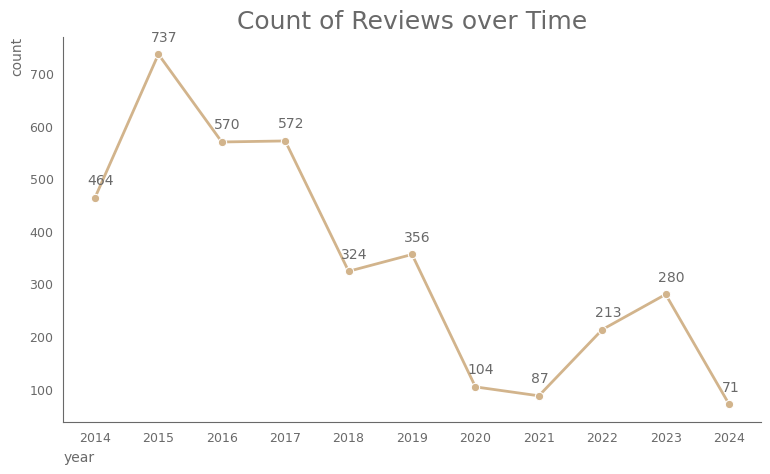

In [23]:
df_count_plot = df['year'].value_counts()

fig, ax = plt.subplots()
ax.set_title('Count of Reviews over Time')

ax = sns.lineplot(df_count_plot, marker='o', linewidth=2, color=COLOR_PLOT)

for x, y in zip(df_count_plot.index, df_count_plot):
    ax.text(x - 0.12, y + 25, s=f'{y:.0f}')

ax.set_ylabel('count')
ax.set_xlabel('year')
ax.set_xticks(df_count_plot.index)

plt.show()

In [24]:
df['rating_value'].describe()

count    3778.000000
mean        4.718105
std         3.175344
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        10.000000
Name: rating_value, dtype: float64

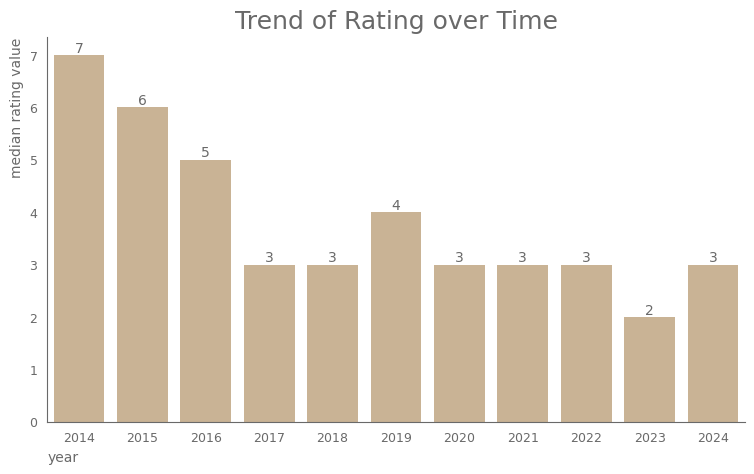

In [25]:
fig, ax = plt.subplots()

ax.set_title('Trend of Rating over Time')

ax = sns.barplot(
    df, x='year', y='rating_value',
    estimator='median', errorbar=None,
    color=COLOR_PLOT
    )

ax.bar_label(ax.containers[0], fmt='%.0f', fontsize=10)

ax.set_ylabel('median rating value')

plt.show()

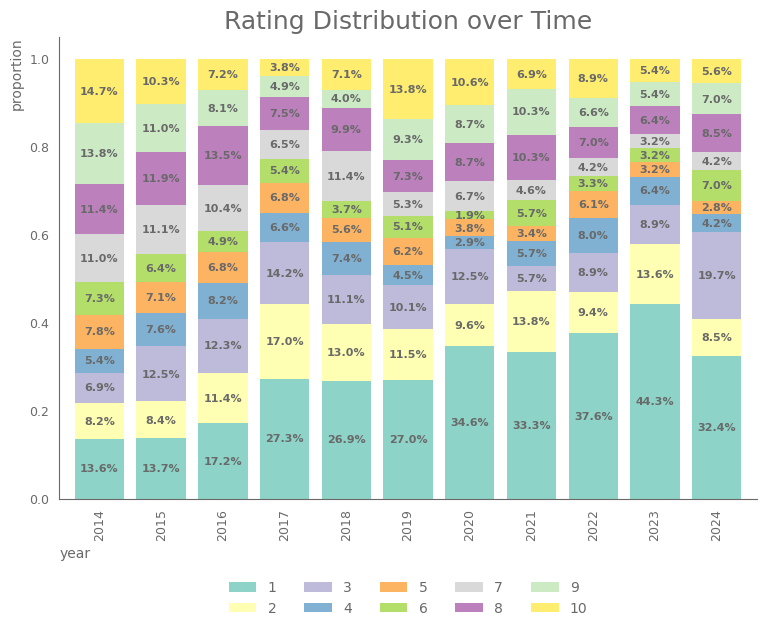

In [26]:
rating_distrib = df.groupby(['year', 'rating_value']).size().unstack()

rating_distrib_prop = pd.crosstab(
    index=df['year'], columns=df['rating_value'], normalize='index'
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.set_title('Rating Distribution over Time')

rating_distrib_prop.plot(kind='bar',
                         stacked=True,
                         ax=ax,
                         width=0.8,
                         colormap='Set3')

ax.legend(bbox_to_anchor=(0.5, -0.15),
          loc='upper center',
          ncol=5,
          frameon=False)

ax.set_ylabel('proportion')

for n, x in enumerate([*rating_distrib.index.values]):
    for proportion, y_loc in zip(
        rating_distrib_prop.loc[x],
        rating_distrib_prop.loc[x].cumsum()
    ):

        plt.text(
            x=n,
            y=(y_loc - proportion) + (proportion / 2),
            s=f'{np.round(proportion * 100, 1)}%',
            va='center',
            ha='center',
            fontsize=8,
            fontweight='bold',
        )

plt.show()

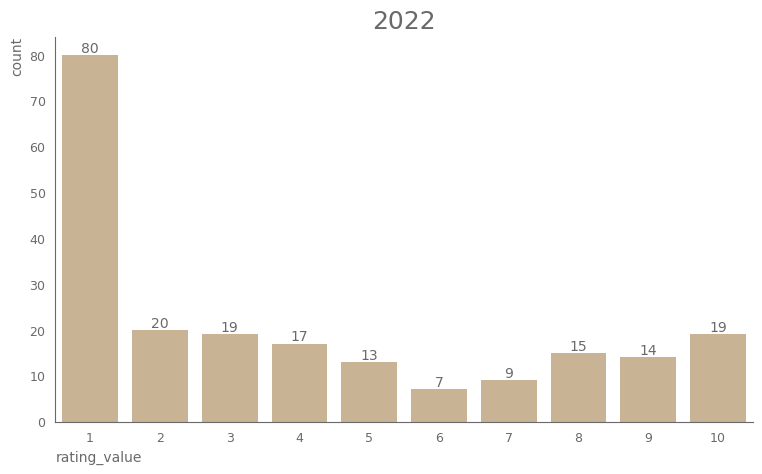

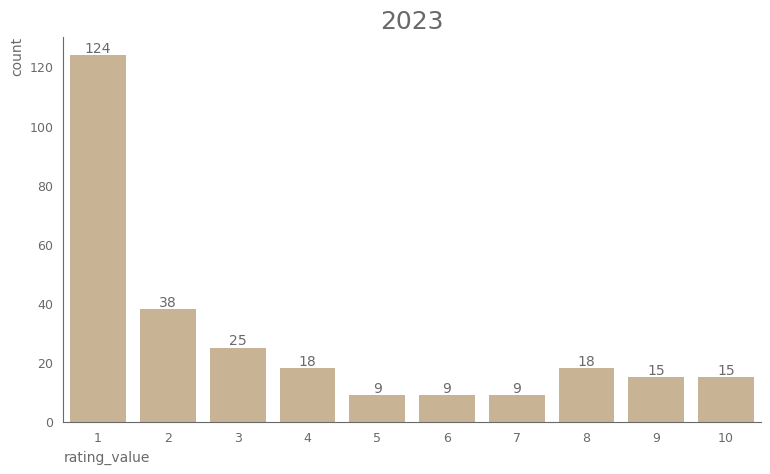

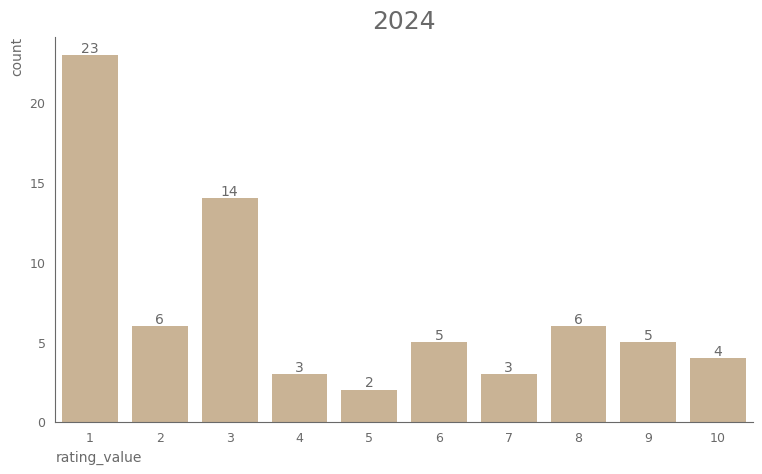

In [27]:
for year in sorted(df['year'].unique())[-3:]:
    plt.title(year)
    ax = sns.countplot(df[df['year'] == year], x='rating_value', color=COLOR_PLOT)
    ax.bar_label(ax.containers[0])
    plt.show()

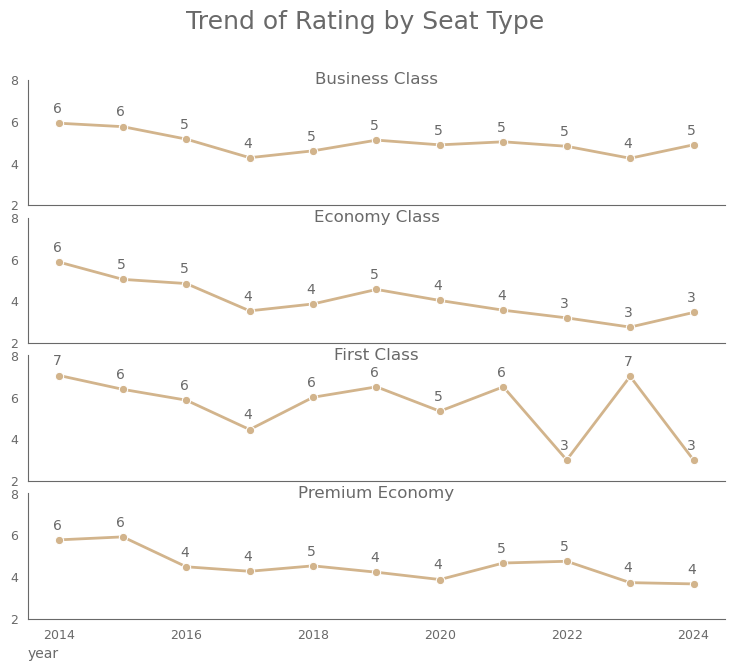

In [28]:
mean_df = (df
           .groupby(['year', 'seat_type'])['rating_value']
           .agg('mean')
           .unstack())

fig = plt.figure(figsize=[9, 7])

gs = fig.add_gridspec(4, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Trend of Rating by Seat Type', fontsize=18)

for i, col in enumerate(mean_df.columns):
    axs[i].set_title(col, loc='center', y=0.9, fontsize=12)
    sns.lineplot(mean_df[col], ax=axs[i], marker='o', linewidth=2, color=COLOR_PLOT)
    for x, y in zip(mean_df.index, mean_df[col]):
        axs[i].text(x - 0.1, y + 0.5, s=f'{y:.0f}')
    axs[i].set_ylim(2, 8)
    axs[i].set_ylabel('')

plt.show()

In [29]:
def plot_pie(df, title):
    explode = [0] * len(df)
    explode[df.argmax()] = 0.1
    plt.title(title)
    plt.pie(
        df,
        labels=df.index,
        autopct='%.1f%%',
        startangle=90,
        textprops={'color': 'black'},
        explode=explode,
        colors=sns.color_palette('Set3'),
    )

    plt.show()

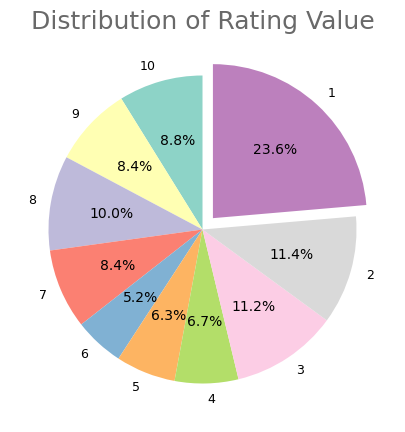

In [30]:
rating_value = (df['rating_value']
                .value_counts()
                .sort_index(ascending=False))

plot_pie(rating_value, 'Distribution of Rating Value')

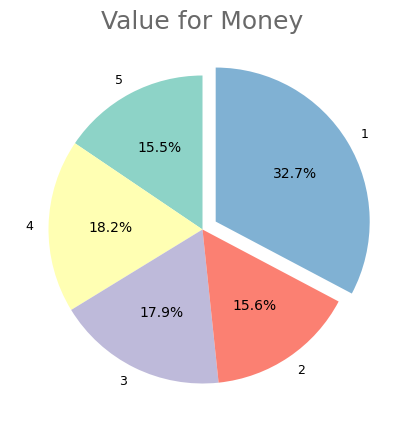

In [31]:
val_for_money = (df['value_for_money']
                 .value_counts()
                 .sort_index(ascending=False))

plot_pie(val_for_money, 'Value for Money')

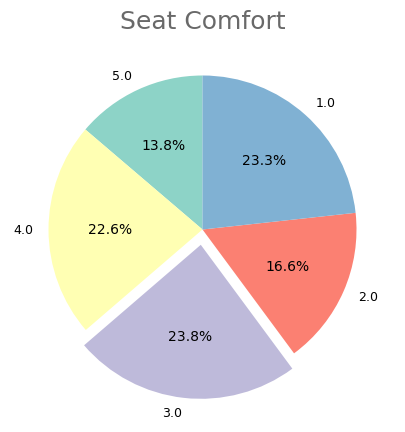

In [32]:
seat_comfort = (df['seat_comfort']
                .value_counts()
                .sort_index(ascending=False))

plot_pie(seat_comfort, 'Seat Comfort')

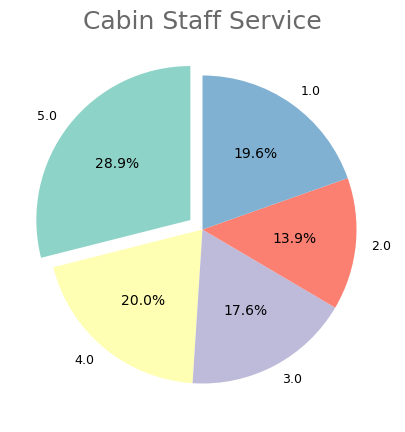

In [33]:
cabin_staff_service = (df['cabin_staff_service']
                       .value_counts()
                       .sort_index(ascending=False))

plot_pie(cabin_staff_service, 'Cabin Staff Service')

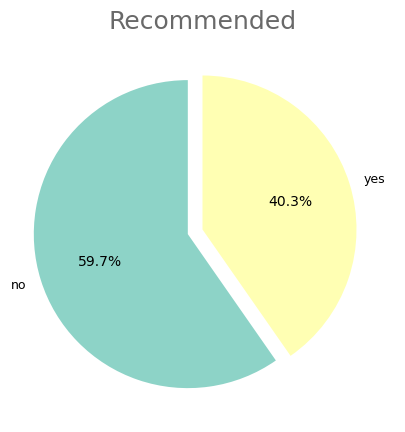

In [34]:
recommended = df['recommended'].value_counts()

plot_pie(recommended, 'Recommended')

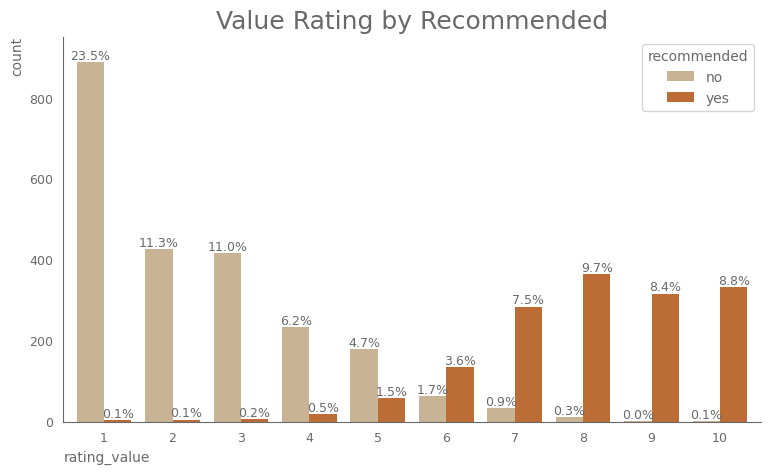

In [35]:
ax = sns.countplot(df, x='rating_value', hue='recommended',
                   palette=[COLOR_PLOT, 'Chocolate'])
total_reviews = df['recommended'].count()
ax.set_title('Value Rating by Recommended')

ax.bar_label(
    ax.containers[0], fmt=lambda x: f'{(x/total_reviews)*100:.1f}%', fontsize=9
)
ax.bar_label(
    ax.containers[1], fmt=lambda x: f'{(x/total_reviews)*100:.1f}%', fontsize=9
)

ax.margins(x=0.02, y=0.07)
plt.show()

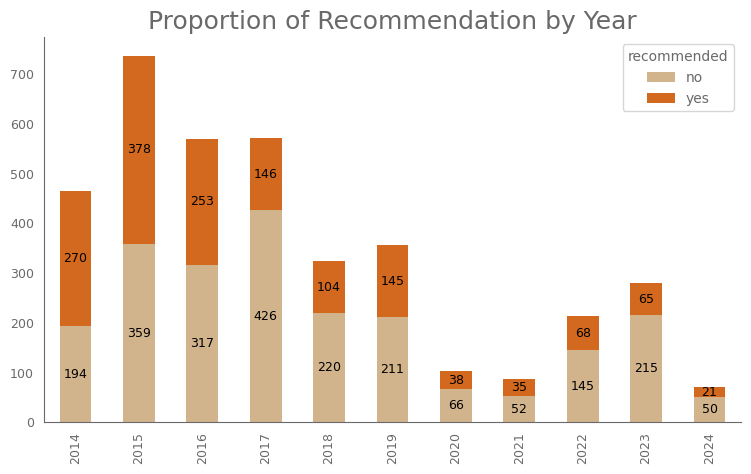

In [36]:
df_plot = (
    df.groupby(['year', 'recommended'])
    .size()
    .reset_index()
    .pivot(columns='recommended', index='year', values=0)
)

fig, ax = plt.subplots()

df_plot.plot(kind='bar', stacked=True, ax=ax, color=[COLOR_PLOT, 'Chocolate'])

plt.title('Proportion of Recommendation by Year')

ax.set_xlabel('')
for c in ax.containers:
    ax.bar_label(
        c,
        fmt=lambda x: f'{x:.0f}' if x > 0 else '',
        label_type='center',
        fontsize=9,
        color='black'
    )

plt.show()

### Analysing Text Reviews

In [37]:
def visualize_top_ngram(corpus: pd.Series,
                        title: str,
                        n: int,
                        max_ngrams: int = 15):
    '''
    List the top ngram
    '''
    vect = CountVectorizer(ngram_range=(n, n), max_features=max_ngrams)
    bag_of_ngrams = vect.fit_transform(corpus)
    sum_ngrams = bag_of_ngrams.sum(axis=0).tolist()[0]
    ngram_freq = zip(vect.get_feature_names_out(), sum_ngrams)
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    x, y = list(map(list, zip(*ngram_freq)))

    ax = sns.barplot(x=y, y=x, color=COLOR_PLOT)
    plt.title(title)
    ax.bar_label(ax.containers[0])
    plt.yticks(fontsize=12)
    plt.show()

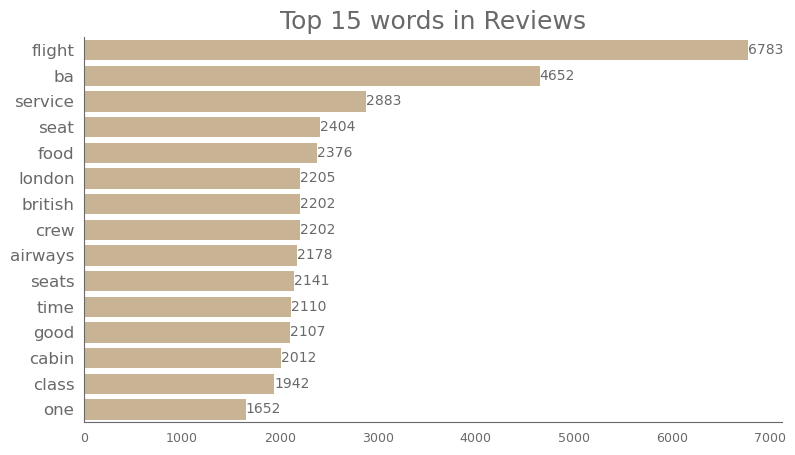

In [37]:
visualize_top_ngram(
    corpus=df['reviews_token'],
    title='Top 15 words in Reviews',
    n=1,
    max_ngrams=15,
)

Such words as 'flight', 'BA', 'British Airways' are found almost every review, so we could add they to stop words.

In [38]:
black_list = ['flight', 'ba', 'british', 'airways']

In [39]:
df['reviews_token_new'] = preprocess_text(df['reviews'].values,
                                          stop_words + black_list)

100%|██████████| 3778/3778 [00:03<00:00, 1146.85it/s]


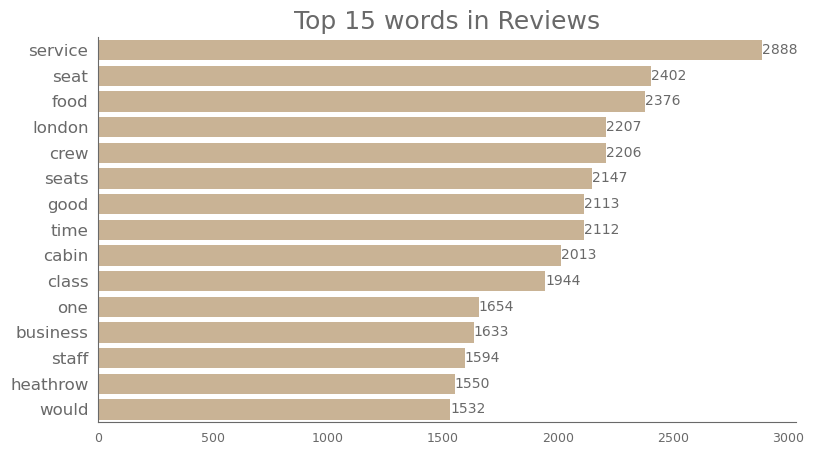

In [40]:
visualize_top_ngram(
    corpus=df['reviews_token_new'],
    title='Top 15 words in Reviews',
    n=1,
    max_ngrams=15,
)

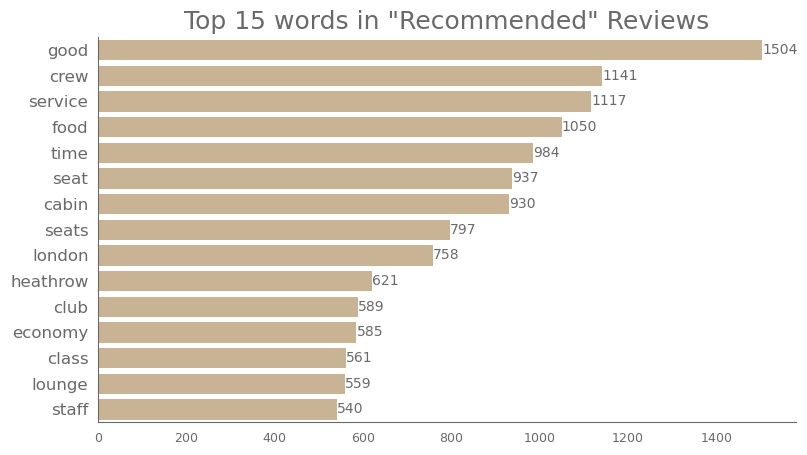

In [41]:
reviews_yes_token = df[df['recommended'] == 'yes']['reviews_token_new']
visualize_top_ngram(
    corpus=reviews_yes_token,
    title='Top 15 words in "Recommended" Reviews',
    n=1,
    max_ngrams=15,
)

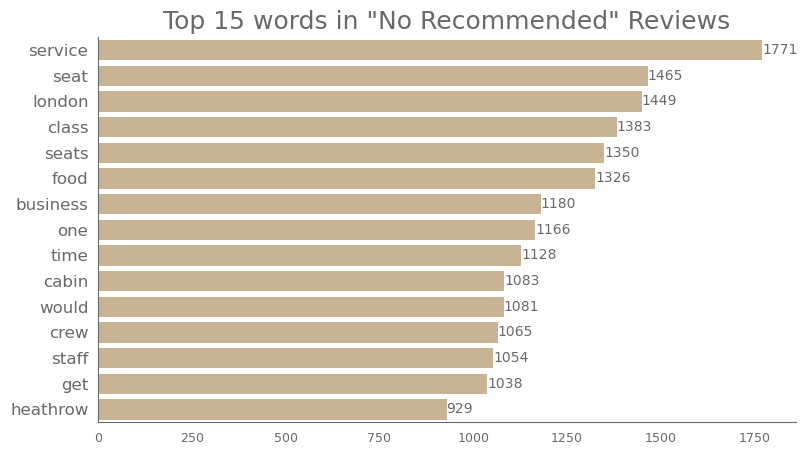

In [42]:
reviews_no_token = df[df['recommended'] == 'no']['reviews_token_new']
visualize_top_ngram(
    corpus=reviews_no_token,
    title='Top 15 words in "No Recommended" Reviews',
    n=1,
    max_ngrams=15,
)

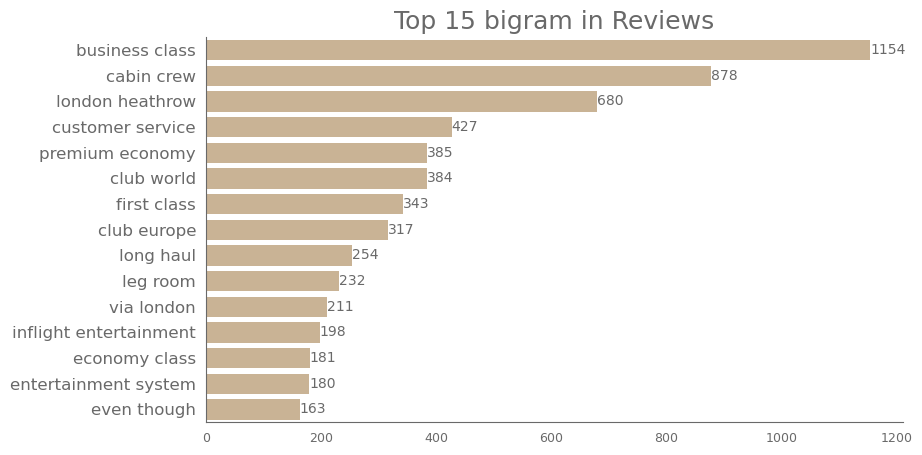

In [43]:
visualize_top_ngram(
    corpus=df['reviews_token_new'],
    title='Top 15 bigram in Reviews',
    n=2,
    max_ngrams=15
)

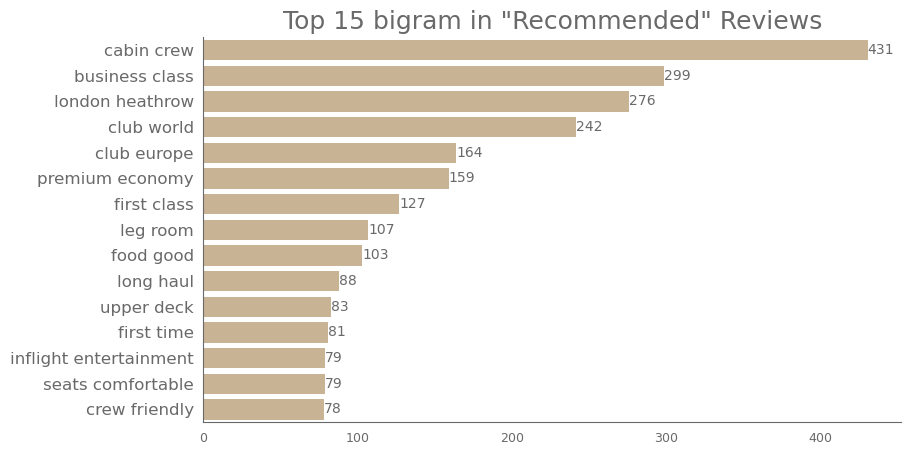

In [44]:
reviews_yes_token = df[df['recommended'] == 'yes']['reviews_token_new']
visualize_top_ngram(
    corpus=reviews_yes_token,
    title='Top 15 bigram in "Recommended" Reviews',
    n=2,
    max_ngrams=15,
)

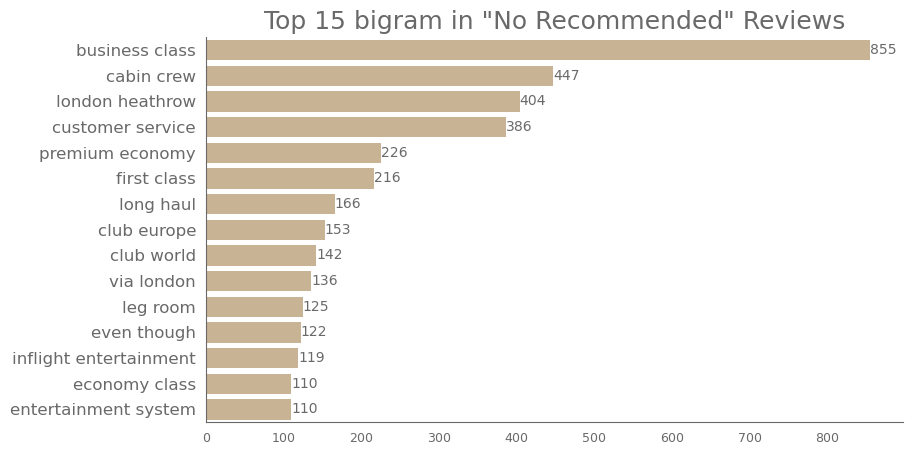

In [45]:
reviews_no_token = df[df['recommended'] == 'no']['reviews_token_new']
visualize_top_ngram(
    corpus=reviews_no_token,
    title='Top 15 bigram in "No Recommended" Reviews',
    n=2,
    max_ngrams=15,
)

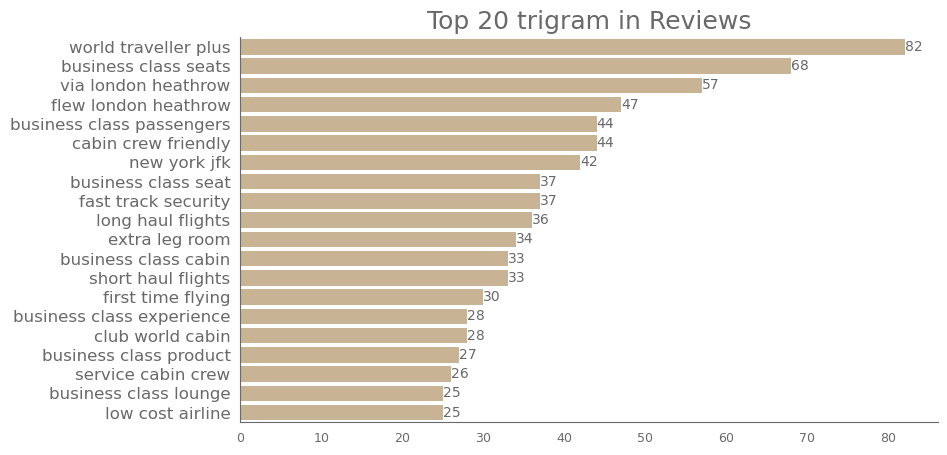

In [46]:
visualize_top_ngram(
    corpus=df['reviews_token_new'],
    title='Top 20 trigram in Reviews',
    n=3,
    max_ngrams=20
)

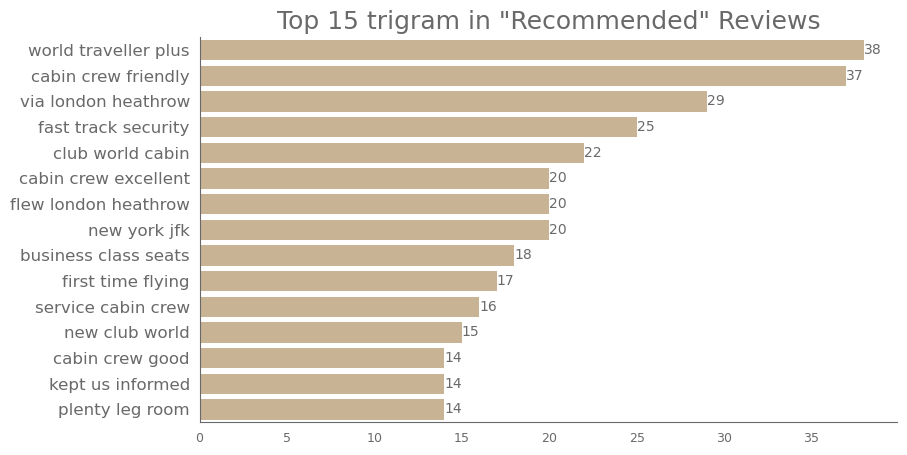

In [47]:
reviews_yes_token = df[df['recommended'] == 'yes']['reviews_token_new']
visualize_top_ngram(
    corpus=reviews_yes_token,
    title='Top 15 trigram in "Recommended" Reviews',
    n=3,
    max_ngrams=15,
)

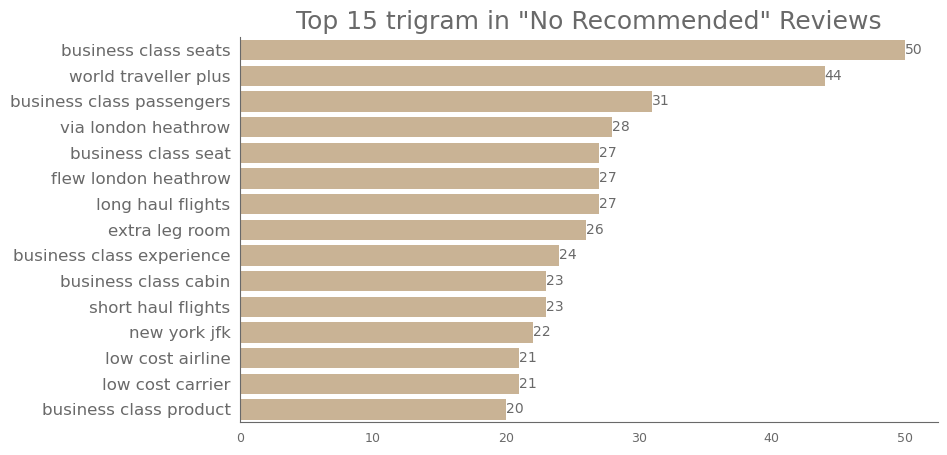

In [48]:
reviews_no_token = df[df['recommended'] == 'no']['reviews_token_new']
visualize_top_ngram(
    corpus=reviews_no_token,
    title='Top 15 trigram in "No Recommended" Reviews',
    n=3,
    max_ngrams=15,
)

#### Sentiment Analysis

In [51]:
analyzer = SentimentIntensityAnalyzer()

def sentiment(text):
    sentiment_dict = analyzer.polarity_scores(text)
    if sentiment_dict['compound'] >= 0.05:
        return 'positive'
    elif sentiment_dict['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [52]:
df['polarity'] = df['reviews_token'].map(lambda x: sentiment(x))

In [53]:
df['polarity'].value_counts(normalize=True)

positive    0.650344
negative    0.332716
neutral     0.016940
Name: polarity, dtype: float64

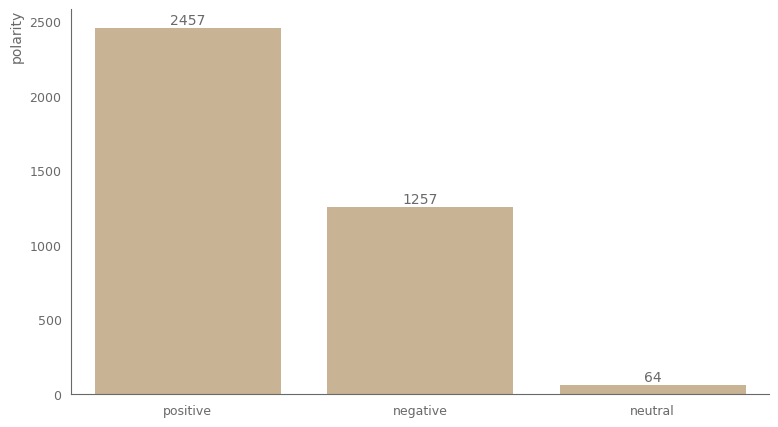

In [54]:
ax = sns.barplot(
    x=df['polarity'].value_counts().index,
    y=df['polarity'].value_counts(),
    color=COLOR_PLOT
)

ax.bar_label(ax.containers[0])
plt.show()

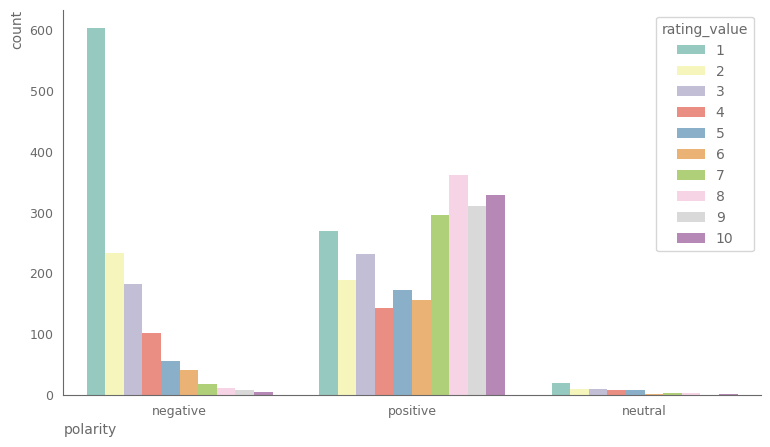

In [55]:
sns.countplot(df, x='polarity', hue='rating_value', palette='Set3')
plt.show()

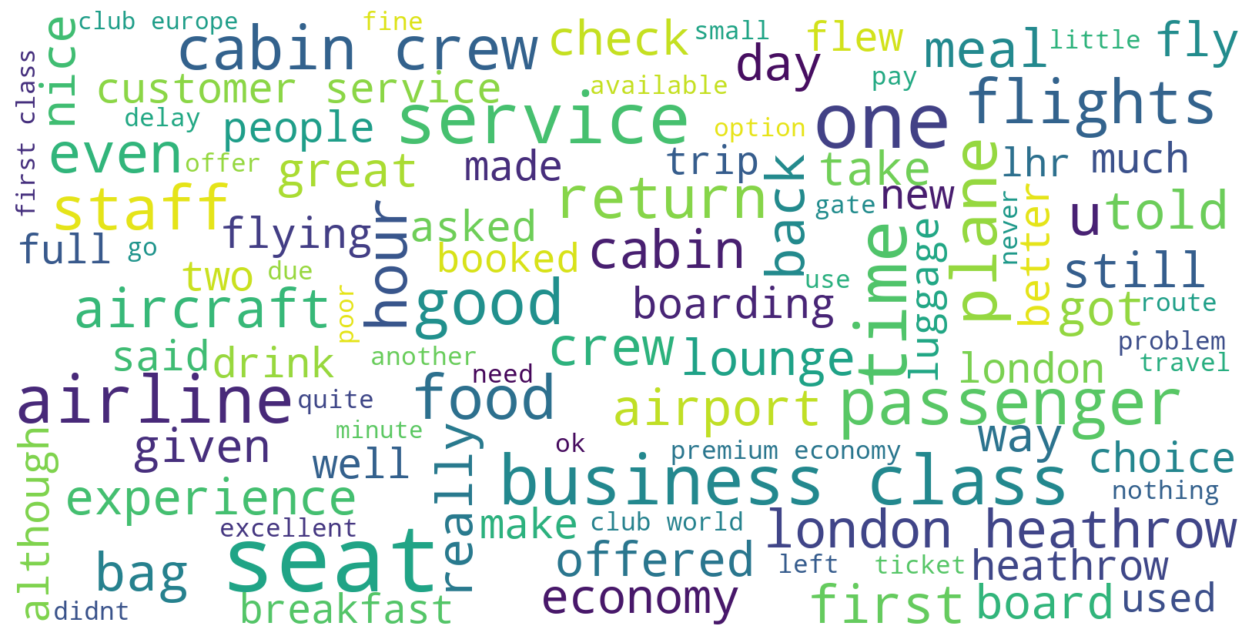

In [56]:
consolidated = ' '.join(word for word in df['reviews_token_new'].astype(str))

wordCloud = WordCloud(
    width=1600,
    height=800,
    max_words=100,
    random_state=24,
    background_color='white',
    max_font_size=120,
)

plt.figure(figsize=(16, 8))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

#### Analysis for last 5 years (2019-2024)

In [57]:
df_5 = df[df['year'] > 2019].copy()
df_5.shape

(755, 21)

In [58]:
df_5['year'].value_counts()

2023    280
2022    213
2020    104
2021     87
2024     71
Name: year, dtype: int64

In [59]:
df_5['rating_value'].describe()

count    755.000000
mean       3.837086
std        3.185461
min        1.000000
25%        1.000000
50%        2.000000
75%        7.000000
max       10.000000
Name: rating_value, dtype: float64

In [60]:
df_5['polarity'].value_counts(normalize=True)

positive    0.531126
negative    0.450331
neutral     0.018543
Name: polarity, dtype: float64

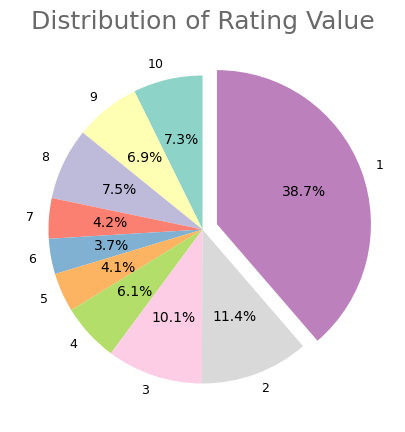

In [61]:
(
    plot_pie(
        df_5['rating_value'].value_counts().sort_index(ascending=False),
        title='Distribution of Rating Value',
    )
)

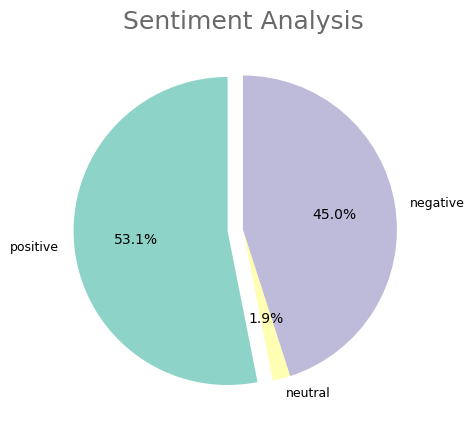

In [62]:
(
    plot_pie(
        df_5['polarity'].value_counts().sort_index(ascending=False),
        title='Sentiment Analysis',
    )
)

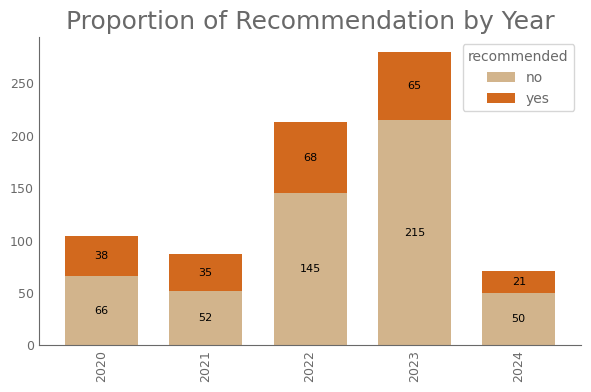

In [63]:
df_5_plot = (
    df_5.groupby(['year', 'recommended'])
    .size()
    .reset_index()
    .pivot(columns='recommended', index='year', values=0)
)

fig, ax = plt.subplots(figsize=(7, 4))

df_5_plot.plot(kind='bar',
               stacked=True,
               ax=ax,
               color=[COLOR_PLOT, 'Chocolate'], width=0.7)

plt.title('Proportion of Recommendation by Year')

ax.tick_params(colors=COLOR_FONT, size=0, labelsize=9, which='both')
ax.set_xlabel('')
for c in ax.containers:
    ax.bar_label(
        c,
        fmt=lambda x: f'{x:.0f}' if x > 0 else '',
        label_type='center',
        fontsize=8,
        color='black',
    )

plt.show()

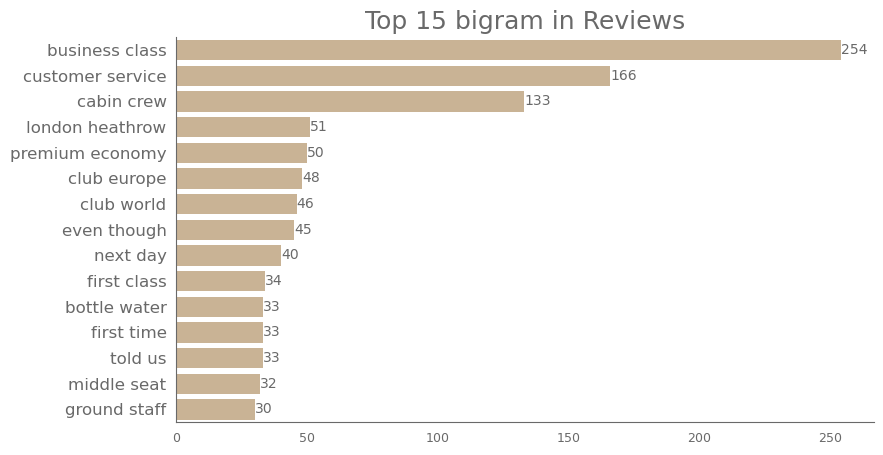

In [64]:
visualize_top_ngram(
    corpus=df_5['reviews_token_new'],
    title='Top 15 bigram in Reviews',
    n=2,
    max_ngrams=15
)

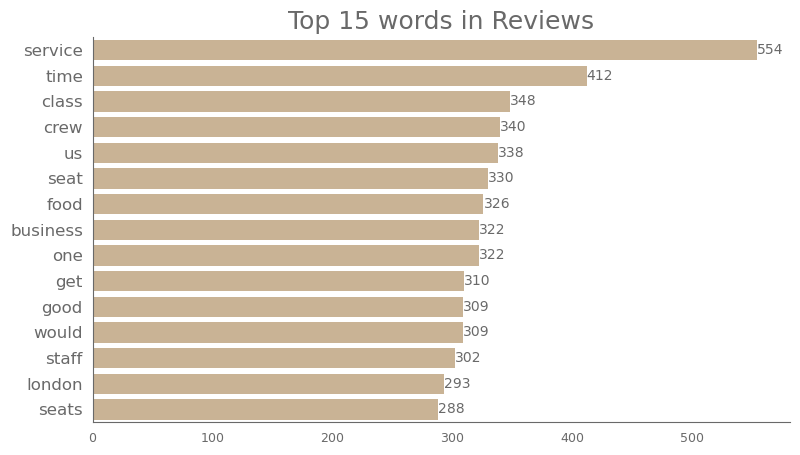

In [65]:
visualize_top_ngram(
    corpus=df_5['reviews_token_new'],
    title='Top 15 words in Reviews',
    n=1,
    max_ngrams=15)